In [2]:
import glob,os,sys,sncosmo,pyParz
import sncosmo
import sntd
from sntd import simulation, fitting,io,models,util
from sntd.plotting import _COLORLIST5
import numpy as np
from scipy import stats
from copy import copy,deepcopy
from astropy.table import vstack
from astropy.io import ascii
from matplotlib import pyplot as plt
from astropy.table import Table

\textbf{If you're just simulating a small number of SNe this is runnable in serial}

Simulated strongly lensed SN 0


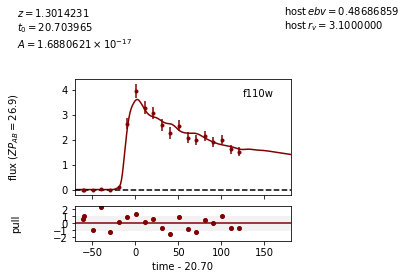

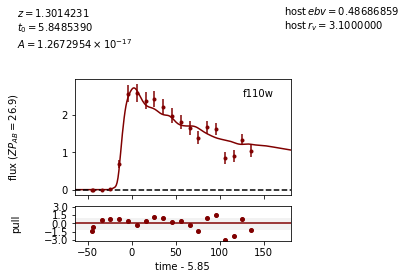

Simulated strongly lensed SN 1


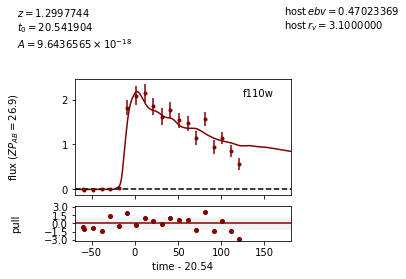

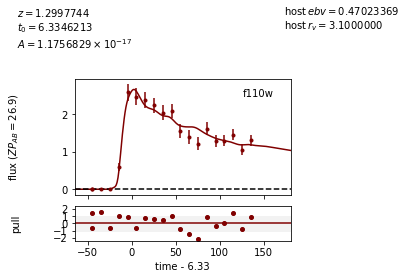

Simulated strongly lensed SN 2


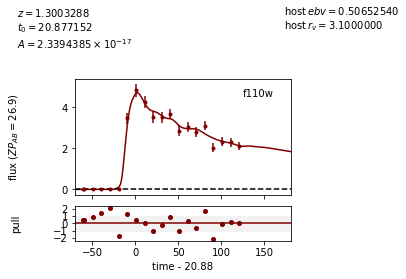

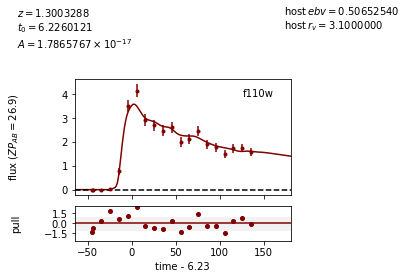

Simulated strongly lensed SN 3


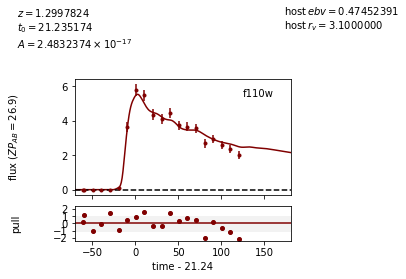

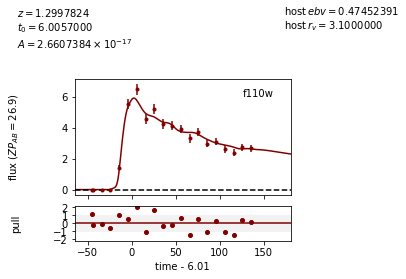

Simulated strongly lensed SN 4


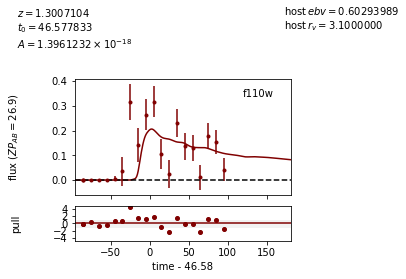

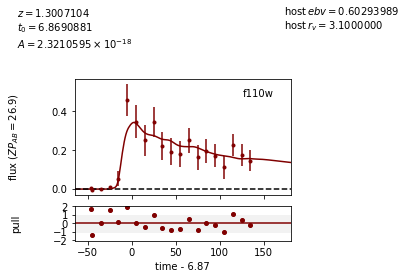

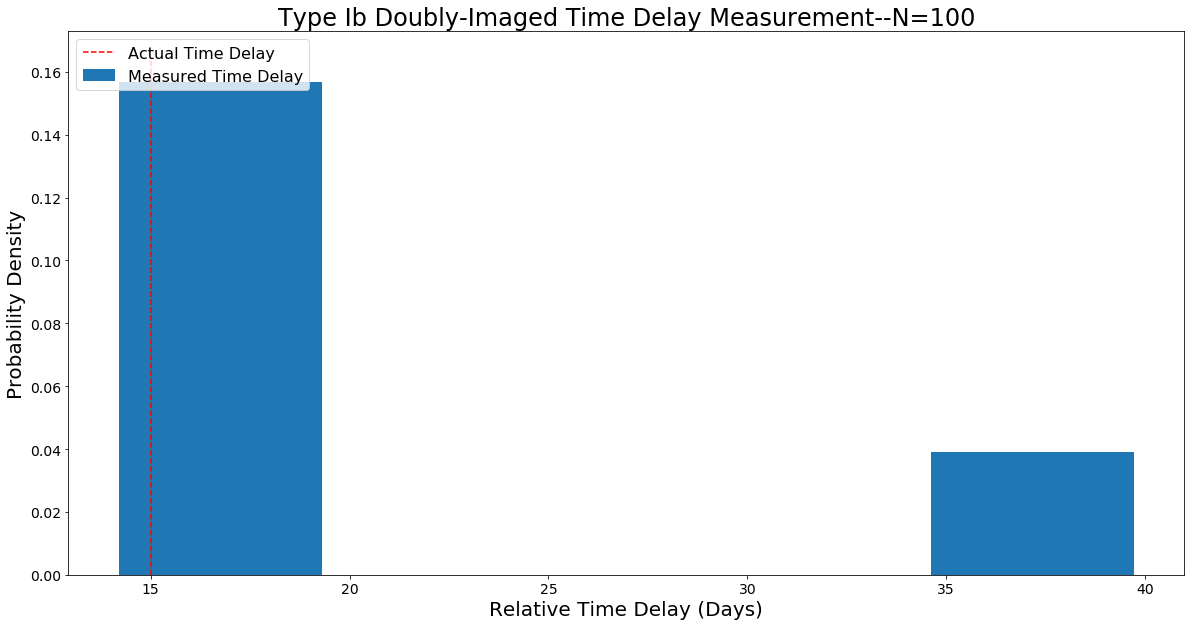

In [30]:
reload(simulation)
reload(fitting)
nsim = 5
dt_fit_list = [] 
murel_fit_list = [] 

times=[-3.932323367086956978e+01,-3.832323367086956978e+01,
       -2.832323367086956978e+01,-1.832323367086956978e+01,
       -8.323233670869569778e+00,1.676766329130430222e+00,
       1.167676632913043022e+01,2.167676632913043022e+01,
       3.167676632913043022e+01,4.167676632913043022e+01,
       5.167676632913043022e+01,6.167676632913043022e+01,
       7.167676632913043022e+01,8.167676632913043022e+01,
       9.167676632913043022e+01,1.016767663291304302e+02,
       1.116767663291304302e+02,1.216767663291304302e+02,
       1.316767663291304302e+02,1.416767663291304302e+02]

for isim in range(nsim):

    # Part 1 : simulate a doubly-imaged Type Ib SN and fit for time delays. Currently 
    #has random spline microlensing implemented, default microlensing type is None
    modname = 'snana-2006iw'#or change to model of type you want
    snType = 'IIP'
    bandlist = ['F110W']
    lcs = simulation.createMultiplyImagedSN(
        modname, snType, 1.3,z_lens=.5, bands=bandlist,
        timeArr=times,zp=26.9, cadence=5., epochs=10.,skynoiseRange=(.001,.005),gain=50. ,
        mjdRange=[0,100.], time_delays=[0., 15.],
        magnifications=np.random.uniform(4,6,2), objectName='Test'+snType, 
        telescopename='HST',microlensing_type=None,
        microlensing_params=[4,2,50],minsnr=5.0)
    
    #lcs.plot_object(showfig=True,savefig=False) #uncomment this and the next 
        #line to show the plot of the simulated SN
    #plt.show()
    
    #print(lcs.images['S1'].simMeta) #uncomment to see the parameters the SN 
        #was created with
    
    print("Simulated strongly lensed SN %i"%isim)

    # Part 2: fit each light curve separately to determine lensing parameters. 
    #You can give whatever bounds you want for the fitting parameters. It 
    #*should* end up at roughly the same solution regardless, but will take longer 
    #to get there if the bounds are bigger. I'll note that the bounds on amplitude 
    #and t0 are relative. If you put amplitude bounds of (.9,1.1) it means within 
    #90%-110% of the max observed flux. If you put a t0 limit of (-10,10) it gives 
    #it bounds of 10 days around max flux. You can also supply the t0_guess parameter 
    #if you have a guess at t0 not near peak flux (maybe a microlensing artifact 
    #distorts the guess), and then the bounds are around that guess. You can make 
    #this faster by changing maxiter on the nest_lc's in the fitting module.
    lcs_tdfit=fitting.fit_data(lcs, snType='IIP', models=['snana-2006iw'],
                               dust='CCM89Dust',effect_frames=['rest'],
                                effect_names=['host'],
                                params=['z','amplitude','t0','hostebv'],
                                bounds={'hostebv':(0,1),'z':(1.28,1.32),'t0':(-15,15)},
                                combined_or_separate='separate',
                                showPlots=True)



    # TODO: we'll make this more general, i.e. use keywords list instead of s1 and s2.
    A_s1 = lcs_tdfit.magnifications['S1']
    A_s2 = lcs_tdfit.magnifications['S2']
    dt_fit_list.append(np.abs(lcs_tdfit.time_delays['S2']))
    murel_fit_list.append(A_s2/A_s1)

#plot the resulting histogram
fig=plt.figure(figsize=(20,10)) 
ax=fig.gca() 
ax.hist(dt_fit_list, bins=5, normed=True,label='Measured Time Delay')

ax.plot([15,15],ax.get_ylim(),'r--',label='Actual Time Delay') 
ax.legend(loc='upper left',fontsize=16) 
ax.set_title('Type Ib Doubly-Imaged Time Delay Measurement--N=100',size=24) 
ax.set_ylabel('Probability Density',size=20) 
ax.set_xlabel('Relative Time Delay (Days)',size=20) 
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.show()
plt.close()

\textbf{If you want to simulate hundreds or thousands of SNe, this is parallelizable.}

Simulating...0
Simulating...1
Simulating...2
Simulating...3

Fitting strongly lensed SN 1
Fitting strongly lensed SN 0
Fitting strongly lensed SN 2
Fitting strongly lensed SN 3


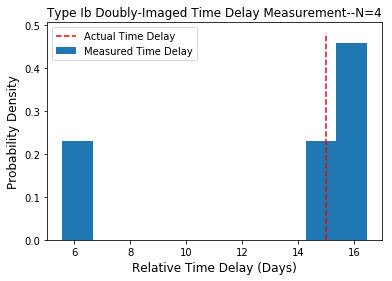

In [20]:
#TODO: Make this parallelization a function inside SNTD
reload(fitting)
nsim = 4
zp=26.0
zpsys='AB'
dt_fit_list = [] 
murel_fit_list = [] 
inds={'time':0,'flux':1,'fluxerr':2,'object':3}
default={'zp':zp,'zpsys':'AB','band':'F125W'}

def _td_par(args):  
    lcs=io.curveDict()
    for t in args:
        temp=Table()
        for name in ['time','band','flux','fluxerr','zp','zpsys']:
            if name in ['time','flux','fluxerr']:
                temp[name]=t[inds[name]]
                
            else:
                
                temp[name]=default[name]
            
        curve_i=io.curve(zp=zp,zpsys=zpsys)
        curve_i.table=temp
        
        curve_i.object=t[inds['object']]
        
        curve_i.bands=['F125W']
        lcs.add_curve(curve_i)

    # Part 2: fit each light curve separately to determine lensing parameters
    print("Fitting strongly lensed SN %i"%args[0][-1])
    lcs_tdfit=fitting.fit_data(lcs, snType='Ib', models=['snana-2006iw'],
                               dust='CCM89Dust',effect_frames=['rest'],
                                effect_names=['host'],
                               params=['z','amplitude','t0','hostebv'],
                               bounds={'hostebv':(0,.5),'z':(1.26,1.34),'t0':(-10,10)},
                               combined_or_separate='separate')
    


    return(np.abs(lcs_tdfit.time_delays['S2']))

simmed=[]
#Currently in order to make unique SNe they need to be created in serial 
#then fit in parallel, I'll look into this
for isim in range(nsim):
    print("Simulating...%i"%isim)
    modname = 'snana-2006iw'
    snType = 'Ib'
    bandlist = ['F125W']
    lcs = simulation.createMultiplyImagedSN(
        modname, snType, 1.3, bands=bandlist,
        zp=zp, skynoiseRange=[0.005,0.02],gain=50.,cadence=5., epochs=10.,
        mjdRange=[0,100.], time_delays=[0., 15.],
        magnifications=np.random.uniform(4,6,2), objectName='Test'+snType, 
        telescopename='HST',z_lens=0.5, 
        microlensing_type='AchromaticSplineMicrolensing',
        microlensing_params=[4,2,50],minsnr=5.0)
    simmed.append([[np.array(lcs.images[k].table['time']),
            np.array(lcs.images[k].table['flux']),
            np.array(lcs.images[k].table['fluxerr']),k,isim] for k in lcs.images.keys()])

print("")
dt_fit_list=pyParz.foreach(simmed,_td_par,None)

#plot the resulting histogram
fig=plt.figure()
ax=fig.gca() 
ax.hist(dt_fit_list,rwidth=1,normed=True,label='Measured Time Delay')

ax.plot([15,15],ax.get_ylim(),'r--',label='Actual Time Delay') 
ax.legend(loc='upper left',fontsize=10) 
ax.set_title('Type Ib Doubly-Imaged Time Delay Measurement--N='+str(nsim),size=12) 
ax.set_ylabel('Probability Density',size=12) 
ax.set_xlabel('Relative Time Delay (Days)',size=12) 
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.show()
plt.close()
#np.savetxt('tds.dat',dt_fit_list) #uncomment to output the histogram data


Simulating...0
0.0
15.0
Simulating...1
0.0
15.0
Simulating...2
0.0
15.0
Simulating...3
0.0
15.0

Fitting strongly lensed SN 3
Fitting strongly lensed SN 1
Fitting strongly lensed SN 2
Fitting strongly lensed SN 0


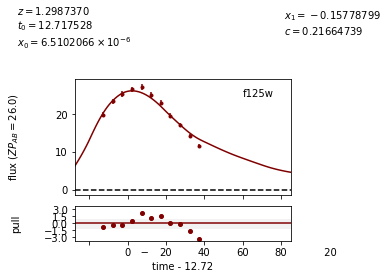

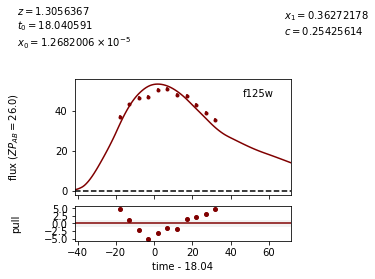

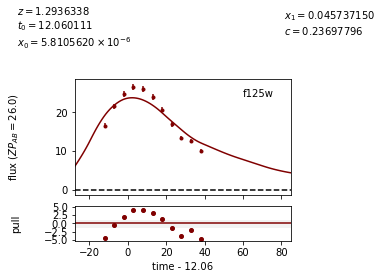

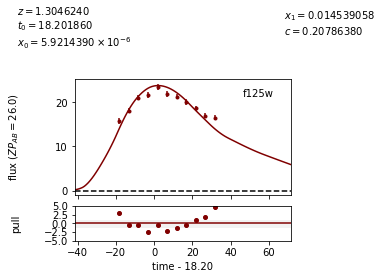

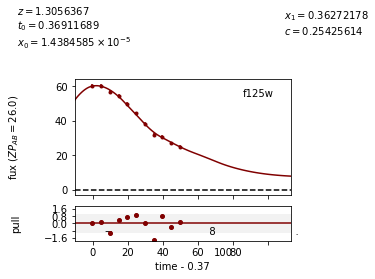

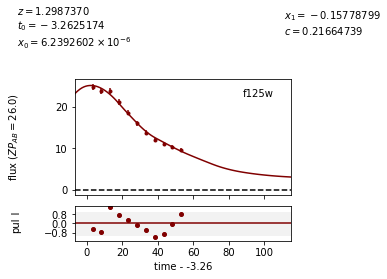

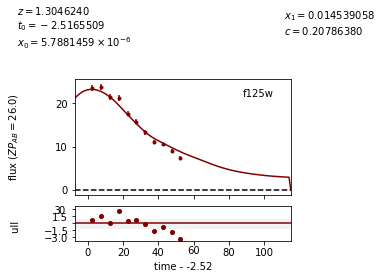

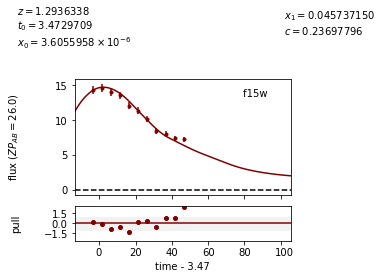

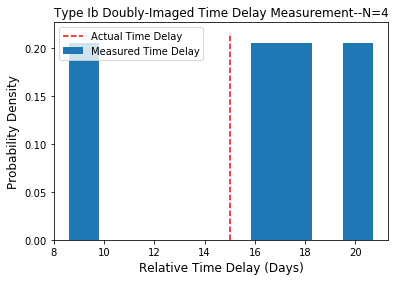

In [31]:
#Running specifically for Ia
#TODO: Make this parallelization a function inside SNTD
reload(fitting)
reload(simulation)
nsim = 4
zp=26.0
zpsys='AB'
dt_fit_list = [] 
murel_fit_list = [] 
inds={'time':0,'flux':1,'fluxerr':2,'object':3}
default={'zp':zp,'zpsys':'AB','band':'F125W'}

def _td_par(args):  
    lcs=io.curveDict()
    for t in args:
        temp=Table()
        for name in ['time','band','flux','fluxerr','zp','zpsys']:
            if name in ['time','flux','fluxerr']:
                temp[name]=t[inds[name]]
                
            else:
                
                temp[name]=default[name]
            
        curve_i=io.curve(zp=zp,zpsys=zpsys)
        curve_i.table=temp
        
        curve_i.object=t[inds['object']]
        
        curve_i.bands=['F125W']
        lcs.add_curve(curve_i)

    # Part 2: fit each light curve separately to determine lensing parameters
    print("Fitting strongly lensed SN %i"%args[0][-1])
    lcs_tdfit=fitting.fit_data(lcs, snType='Ia', models=[salt2],
                               dust='CCM89Dust',
                               params=['z', 't0', 'x0', 'x1', 'c'],
                               bounds={'c':(0,.5),'z':(1.26,1.34),'t0':(-10,10)},
                               combined_or_separate='separate',showPlots=True)
    


    return(np.abs(lcs_tdfit.time_delays['S2']))

simmed=[]
#Currently in order to make unique SNe they need to be created in serial 
#then fit in parallel, I'll look into this
#You need to use this version of salt2 if looking at high-z, extends to 
#25000A (Pierel 2018)
salt2=sncosmo.SALT2Source(modeldir='salt2-extended')
for isim in range(nsim):
    print("Simulating...%i"%isim)
    modname = salt2
    snType = 'Ia'
    bandlist = ['F125W']
    lcs = simulation.createMultiplyImagedSN(
        modname, snType, 1.3, bands=bandlist,
        zp=zp, skynoiseRange=[0.005,0.02],gain=50.,cadence=5., epochs=10.,
        mjdRange=[0,100.], time_delays=[0., 15.],
        magnifications=np.random.uniform(4,6,2), objectName='Test'+snType, 
        telescopename='HST',z_lens=0.5, 
        microlensing_type='AchromaticSplineMicrolensing',
        microlensing_params=[4,2,50],minsnr=5.0)
    simmed.append([[np.array(lcs.images[k].table['time']),
            np.array(lcs.images[k].table['flux']),
            np.array(lcs.images[k].table['fluxerr']),k,isim] for k in lcs.images.keys()])

print("")
dt_fit_list=pyParz.foreach(simmed,_td_par,None)

#plot the resulting histogram
fig=plt.figure()
ax=fig.gca() 
ax.hist(dt_fit_list,rwidth=1,normed=True,label='Measured Time Delay')

ax.plot([15,15],ax.get_ylim(),'r--',label='Actual Time Delay') 
ax.legend(loc='upper left',fontsize=10) 
ax.set_title('Type Ib Doubly-Imaged Time Delay Measurement--N='+str(nsim),size=12) 
ax.set_ylabel('Probability Density',size=12) 
ax.set_xlabel('Relative Time Delay (Days)',size=12) 
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.show()
plt.close()
#np.savetxt('tds.dat',dt_fit_list) #uncomment to output the histogram data


\textbf{You can also fit with a parameterized model if you want, to simulate the case where we don't know the redshift or the SN Type}

In [ ]:
#TODO: Make this parallelization a function inside SNTD
nsim = 4
zp=26.0
zpsys='AB'
dt_fit_list = [] 
murel_fit_list = [] 
inds={'time':0,'flux':1,'fluxerr':2,'object':3}
default={'zp':zp,'zpsys':'AB','band':'F125W'}

def _td_par(args):  
    lcs=io.curveDict()
    for t in args:
        temp=Table()
        for name in ['time','band','flux','fluxerr','zp','zpsys']:
            if name in ['time','flux','fluxerr']:
                temp[name]=t[inds[name]]
                
            else:
                
                temp[name]=default[name]
            
        curve_i=io.curve(zp=zp,zpsys=zpsys)
        curve_i.table=temp
        
        curve_i.object=t[inds['object']]
        
        curve_i.bands=['F125W']
        lcs.add_curve(curve_i)

    print("Fitting strongly lensed SN %i"%args[0][-1])
    bds={'t0':(-10,10),'amplitude':(.8,1.35),'k':(.2,.75),'sigma':(5,20),'s':(0,.2)}
    lcs_tdfit=fitting.fit_data(lcs, snType='Ib', models=['PierelSource'],
                               dust='CCM89Dust',effect_frames=['rest'],
                                effect_names=['host'],
                               params=['k','sigma','amplitude','t0','s'],
                               bounds=bds,
                               combined_or_separate='separate',showPlots=True)
    

    return(np.abs(lcs_tdfit.time_delays['S2']))

simmed=[]
#Currently in order to make unique SNe they need to be created in 
#serial then fit in parallel, I'll look into this
for isim in range(nsim):
    print("Simulating...%i"%isim)
    modname = 'snana-2004gv'
    snType = 'Ib'
    bandlist = ['F125W']
    lcs = simulation.createMultiplyImagedSN(
        modname, snType, 1.3, bands=bandlist,
        zp=zp, skynoiseRange=[0.005,0.02],gain=50.,cadence=5., 
        epochs=10.,mjdRange=[0,100.], time_delays=[0., 15.],
        magnifications=np.random.uniform(4,6,2), objectName='Test'+snType, 
        telescopename='HST',z_lens=0.5, 
        microlensing_type='AchromaticSplineMicrolensing',
        microlensing_params=[4,2,50],minsnr=5.0)
    simmed.append([[np.array(lcs.images[k].table['time']),
            np.array(lcs.images[k].table['flux']),
            np.array(lcs.images[k].table['fluxerr']),k,isim] for k in lcs.images.keys()])

print("")
dt_fit_list=pyParz.foreach(simmed,_td_par,None)

#plot the resulting histogram
fig=plt.figure()
ax=fig.gca() 
ax.hist(dt_fit_list,rwidth=1,normed=True,label='Measured Time Delay')

ax.plot([15,15],ax.get_ylim(),'r--',label='Actual Time Delay') 
ax.legend(loc='upper left',fontsize=10) 
ax.set_title('Type Ib Doubly-Imaged Time Delay Measurement--N='+str(nsim),size=12) 
ax.set_ylabel('Probability Density',size=12) 
ax.set_xlabel('Relative Time Delay (Days)',size=12) 
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.show()
plt.close()
#np.savetxt('tds.dat',dt_fit_list) #uncomment to output the histogram data
